# Extract data from FCE's xml files

In [ ]:
import sys
print(sys.version)

In [ ]:
import glob, os

folderPath = "/Users/XXX/Dropbox/Python/working/FCE/**/"

filenames = glob.glob(os.path.join(folderPath, "*.xml"))

In [ ]:
len(filenames)

In [ ]:
from bs4 import BeautifulSoup

lang = []
for i in filenames:
    with open(i) as doc:
        soup = BeautifulSoup(doc, "xml")
        for language in soup.find_all('language'):
            lang.append(language.text)

In [ ]:
len(lang)

In [ ]:
import collections

c = collections.Counter(lang)
print(c)

In [ ]:
len(c.keys())

In [ ]:
sum(c.values())

In [ ]:
from bs4 import BeautifulSoup
import pandas as pd
import os

df_cols = ["fileno", "lang", "age", "score", "q_no1", "no1_score", "no1_resp", "no1_tagNum", "q_no2", "no2_score", "no2_resp", "no2_tagNum"]

rows = []

for i in filenames:
    # Remove the extension from the last part of the filename
    fileno = os.path.splitext(os.path.basename(i))[0]
    with open(i, encoding='utf-8-sig') as doc:
        soup = BeautifulSoup(doc, "xml")
        for each in soup:
            lang = each.find('language').text
            # Include only 'Korean', 'Japanese', 'Chinese'
            if lang in ['Korean', 'Japanese', 'Chinese']:
                if each.find('age'):
                    age = each.find('age').text
                else:
                    age = "NA"
                score = each.find('score').text

                for element in soup.find_all('answer1'):
                    q_no1 = element.find('question_number').text
                    no1_score = element.find('exam_score').text.replace('T', '') if element.find('exam_score') else "NA"
                    # Skip if no1_score is "NA"
                    if no1_score == "NA":
                        continue
                    no1_resp = element.find('coded_answer')
                    no1_tagNum = len(element.find_all("NS"))

                    for element in soup.find_all('answer2'):
                        q_no2 = element.find('question_number').text
                        if element.find('exam_score'):
                            no2_score = element.find('exam_score').text
                        else:
                            no2_score = "NA"
                        no2_resp = element.find('coded_answer')
                        no2_tagNum = len(element.find_all("NS"))

                    rows.append({"fileno": fileno, "lang": lang, "age": age, "score": score,
                                 "q_no1": q_no1, "no1_score": no1_score, "no1_resp": no1_resp, "no1_tagNum": no1_tagNum,
                                 "q_no2": q_no2, "no2_score": no2_score, "no2_resp": no2_resp, "no2_tagNum": no2_tagNum})

df_all = pd.DataFrame(rows, columns=df_cols)

In [ ]:
df_all

In [ ]:
df_all.to_csv('df_all.csv')

In [ ]:
df_all['lang'].value_counts()

# Preprocess the Writing Question No.1 data

In [ ]:
import pandas as pd
import re
from bs4 import BeautifulSoup
import nltk
from nltk.tokenize.punkt import PunktSentenceTokenizer, PunktTrainer, PunktParameters

nltk.download('punkt')

# Exceptions
exception_list = ["a.m.", "A.M.", "p.m.", "P.M.", "P.S.", "U.S.A.", "U.S.", "A.S.A.P.", "e.g.", "Dr.", "Mr.", "Mrs.", "Ms."]

training_text = """
Dear Mrs. Helen Ryan
Good morning, I usually wake up at 6 a.m. and start working by 8 a.m. In the evening, I relax after 6 p.m. or sometimes 7 p.m.
Please read the document e.g. the one from Dr. Smith. It's urgent, so do it A.S.A.P. 
Mr. Johnson and Mrs. Johnson will join us from the U.S.A. next week. The meeting with Ms. Brown is scheduled for tomorrow.
P.S. Don't forget to check the report from the U.S. office. Mrs. Smith and Mrs. Anderson have already reviewed it.
Yesterday, I met Mrs. White and Mrs. Clark at the event. Mrs. White is from the U.K., and Mrs. Clark is from the U.S.
Mrs. Helen Ryan will be attending the meeting tomorrow. We also expect Mrs. Emily Johnson to arrive by noon.
"""

training_text += """
You mentioned that "Your perfect evening out!" in your advert. This is an example where a sentence continues after an exclamation mark inside quotes.
Another example is "Wow!" said John, "I didn't expect that to happen." where the sentence continues after the exclamation mark.
"""

punkt_param = PunktParameters()
punkt_param.abbrev_types = set(exception_list)
punkt_param.collocations = False  
tokenizer = PunktSentenceTokenizer(punkt_param)

trainer = PunktTrainer()
trainer.INCLUDE_ALL_COLLOCS = False
trainer.train(training_text)
tokenizer = PunktSentenceTokenizer(trainer.get_params())


def split_sentences_with_tags(text, tokenizer):
    sentences = tokenizer.tokenize(text)
    sentences_with_tags = [sentence for sentence in sentences]
    return sentences_with_tags


def keep_i_tags_remove_c_tags(text):
    soup = BeautifulSoup(text, 'html.parser')
    for c_tag in soup.find_all('c'):
        c_tag.decompose()
    for tag in soup.find_all(True):
        if tag.name != 'i':
            tag.unwrap()
        else:
            if tag.string:
                tag.replace_with(tag.string)
    cleaned_text = str(soup)
    cleaned_text = re.sub(r' {2,}', ' ', cleaned_text)
    cleaned_text = re.sub(r'</?i>', '', cleaned_text)
    return cleaned_text


def replace_special_cases(text):
    text = re.sub(r'<i>\. There</i>', '<TEMP_DOT> There', text)
    text = re.sub(r'<i>\. It</i>', '<TEMP_DOT> It', text)
    text = re.sub(r'evening out\!" in your advert', 'evening out<TEMP_EXQ>" in your advert', text)
    return text


def process_text(text, tokenizer):
    # Use BeautifulSoup to parse the HTML/XML
    soup = BeautifulSoup(str(text), 'html.parser')

    # Initialize lists for processed data
    original_sentences = []
    processed_sentences = []
    tag_counts = []

    # Split paragraphs and process each
    paragraphs = soup.find_all('p')
    for p in paragraphs:
        # Convert paragraph to string
        paragraph_str = str(p)

        # Replace special cases before tokenizing
        paragraph_str = replace_special_cases(paragraph_str)

        # Tokenize the paragraph into sentences
        sentences = tokenizer.tokenize(paragraph_str)
        for sentence in sentences:
            # Replace the placeholder back to the original pattern
            sentence = sentence.replace('<TEMP_DOT>', '.')
            sentence = sentence.replace('<TEMP_EXQ>', '!')
            
            # Add the original sentence (with HTML tags) to the list
            original_sentences.append(sentence)

            # Process the sentence to remove <c> tags and count other tags
            processed_sentence = BeautifulSoup(sentence, 'html.parser')
            for c_tag in processed_sentence.find_all('c'):
                c_tag.decompose()

            tag_count = len(processed_sentence.find_all('ns'))
            tag_counts.append(tag_count)

            # Clean up the processed sentence
            cleaned_sentence = processed_sentence.get_text()
            cleaned_sentence = re.sub(r'  +', ' ', cleaned_sentence).strip()
            processed_sentences.append(cleaned_sentence)

    return original_sentences, processed_sentences, tag_counts


fileno_list = []
original_resps = []
tag_nums = []
cleaned_resps = []

for index, row in df_all.iterrows():
    fileno = row['fileno']
    no1_resp = row['no1_resp']

    original_sentences, processed_sentences, tag_counts = process_text(no1_resp, tokenizer)
    for original_sentence, cleaned_sentence, tag_count in zip(original_sentences, processed_sentences, tag_counts):
        fileno_list.append(fileno)
        original_resps.append(original_sentence)
        tag_nums.append(tag_count)
        cleaned_resps.append(cleaned_sentence)

# Create the new DataFrame
processed_df = pd.DataFrame({
    'fileno': fileno_list,
    'original_resp': original_resps,
    'tag_num': tag_nums,
    'cleaned_resp': cleaned_resps
})

# Change"&lt;TEMP_DOT&gt;" to a period
processed_df['original_resp'] = processed_df['original_resp'].str.replace('&lt;TEMP_DOT&gt;', '.', regex=False)
processed_df['cleaned_resp'] = processed_df['cleaned_resp'].str.replace('&lt;TEMP_DOT&gt;', '.', regex=False)

# Display the head of the processed DataFrame
processed_df.head()

In [ ]:
# Filter out lines in the cleaned_resp column of processed_df that have opening parentheses in the sentence and closing parentheses missing
missing_closing_parenthesis = processed_df[processed_df['cleaned_resp'].str.contains('\(') & ~processed_df['cleaned_resp'].str.contains('\)')]
missing_closing_parenthesis

In [ ]:
for index, row in processed_df.iterrows():
    cleaned_sentence = row['cleaned_resp']
    open_parens = cleaned_sentence.count('(')
    close_parens = cleaned_sentence.count(')')
    if open_parens > close_parens:
        cleaned_sentence += ')' * (open_parens - close_parens)
        processed_df.at[index, 'cleaned_resp'] = cleaned_sentence

#processed_df.head()

In [ ]:
#processed_df.to_csv('processed_df.csv')

In [ ]:
def filter_sentences(sentence):
    lower_sentence = sentence.lower()

    if lower_sentence.startswith("dear") or lower_sentence.startswith(" dear"):
        return False
    if lower_sentence.startswith("yours"):
        return False
    if not sentence.strip():
        return False
    if re.match(r'^\d{1,2}(st|nd|rd|th)?\s(jan|feb|mar|apr|may|jun|jul|aug|sep|oct|nov|dec)\b', lower_sentence):
        return False
    if "faithfully" in lower_sentence or "sincerely" in lower_sentence:
        return False
    if re.match(r'^\w+( \w+)?\.?!$', lower_sentence):
        return False
    if lower_sentence[0].isdigit():
        return False
    if re.match(r'^[\.\,\!\?;:\'\"]+$', lower_sentence):
        return False
    if re.match(r'^how$', lower_sentence):
        return False

    return True

processed_df = processed_df[processed_df['cleaned_resp'].apply(filter_sentences)]

In [ ]:
words_to_remove =[
        ")", "Your Sincelery,", "St Albans", "AL1 2HW", "Tyung Kwa (Miss)", "To.", "Hi.",
        "Thank you.", "Bye for now", "Best regards.", "Taeron Jon", "Kwa Phat Sun.", "Elsy Sun.", "Sun-Young Lee.",
        "P.S.", "sincinerly from Ki", "from", "TA HYUN PHAT", "TYUNG, SURIPHAT",
        "Saturday, June, 17th", "best regards,", "Ring T Lun", "Ko Hyu Tung", "Lo Son Lin.",
        "(Hotel number).", "Ann Kim.", "L.", "P. Lou", "Silvie.", "Bying Kak",
        "Chu Jin-Sun.", "Phat Cheung", "June 17, 2000", "Yeung", "Kowloon, Hong Kong.",
        "July 17, 2000", "Yu Phu Tung.", "Thanks loads", "Kyon Chwa", "Truly,",
        "Yun Sandra", "how.", "JIA LI LO", "SHE DUNES", "Yumi Nakamura", "Makoto Tanaka",
        "Annabel Koh", "MIDORI FUYU", "JAE KWAI", "Ae-Sook Pak", "KANG OFF WOO", 
        "Clark.", "Jae Hwa.", "Kim.", "Lee. Han", "Best Regards", "Chi Chen",
        "Bae Ki Seul", "Hideo Kojima", "Regina Kong", "Helen. Ryan,", "Hana Soma",
        "Yuna ARNISTON", "Chi Kimura", "Best wishes.", "Satomi Fukao", "AS3 7GH, London",
        "Mrs. Helen Ryan", "Competition Organiser", "Mee-Yon Areum.", "Thanks",
        "Shin Parade", "Takashi Oshima.", "Helen Ryan.", "JUAN LILY LEE", "Kan Seo",
        "June.", "YEUN-Ja. HONG", "(Au Kwan Ming)", "Best Wishes", "To Mr. Robertson", "Sir Robertson,",
        "Thank you.", "your students.", "X teacher.", "faithful", "Your sincerly",
        "To: Mrs. Smith", "Love from,", "Maria Smith.", "TA HYUN PHAT", "Jon Sun.",
        "Alessandra Lane.","To Manager.", "Yoshiko Murasaki", "Rie Tanizaki","To Helen Ryan,",
        "Best riger.","To Mr Robertson,", "Lee.", "Han", "Ryan,", "Mrs.", "Helen Ryan", "YEUN-Ja.", "HONG", 
        "March, 2000", "BO-PHAT SUN (MS)"
]

def filter_specific_words(sentence):
    trimmed_sentence = sentence.strip().lower()

    if trimmed_sentence in [word.lower() for word in words_to_remove]:
        return False
    return True

processed_df_filtered = processed_df[processed_df['cleaned_resp'].apply(filter_specific_words)]

In [ ]:
#processed_df_filtered.to_csv('processed_df_filtered.csv', encoding='utf-8-sig')

# Line-by-line Raw Data 

In [4]:
import pandas as pd

df = pd.read_csv('processed_df_filtered.csv', encoding='utf-8-sig')
df.drop(columns=['Unnamed: 0'], inplace=True)
df.insert(0, 'ID', range(1, len(df) + 1))

df

,ID,fileno,original_resp,tag_num,cleaned_resp
0,1,doc2121,"<p>I'm one of the <ns type=""RN""><i><ns type=""A...",2,I'm one of the citizen that enjoyed the last I...
1,2,doc2121,"Most of <ns type=""MD""><c>the</c></ns> attracti...",9,"Most of attractions are excellent, but I'd lik..."
2,3,doc2121,"<p>First of all, <ns type=""R"">the only ""six co...",1,"First of all, the only ""six countries"" doesn't..."
3,4,doc2121,"I suppose you had difficulty <ns type=""FV""><i>...",1,I suppose you had difficulty to manage the sch...
4,5,doc2121,"<p>Second, some concert <ns type=""AGN""><i>hall...",4,"Second, some concert hall were too small, so s..."
...,...,...,...,...,...
3097,3098,doc3152,"It might be a great party for <ns type=""MD""><c...",2,It might be a great party for end of conference.
3098,3099,doc3152,"<p><ns type=""R"">End of all</ns>, in my opinion...",6,"End of all, in my opinion we could go a center..."
3099,3100,doc3152,"It's quite a nice <ns type=""MN""><c>area</c></n...",2,It's quite a nice and a suitable place to spen...
3100,3101,doc3152,It could be interesting for them.</p>,0,It could be interesting for them.


In [ ]:
#df.to_csv('df.csv', encoding='utf-8-sig')

## Create a clean text file for each participant

In [5]:
import os
import re
# Create a directory to save the text files
directory = './fileno_texts'
if not os.path.exists(directory):
    os.makedirs(directory)

# Group the data by 'fileno' and concatenate 'cleaned_resp' texts
grouped_texts = df.groupby('fileno')['cleaned_resp'].apply(lambda x: ' '.join(x))

# Adjusting the code to correctly split sentences based on the specified delimiters (. ? ! ))
for fileno, text in grouped_texts.items():
    # Using regular expressions to split the text into sentences
    sentences = re.split(r'(?<=[.?!)])\s+', text)
    formatted_text = '\n'.join(sentences)

    file_path = os.path.join(directory, f"{fileno}.txt")
    with open(file_path, 'w') as file:
        file.write(formatted_text)

# Confirming the process
"Text files updated with sentences split correctly."

'Text files updated with sentences split correctly.'

## Count the number of errors

In [6]:
# Grouping the data by 'fileno' and calculating sum and average of 'tag_num'
grouped_data = df.groupby('fileno')['tag_num'].agg(['sum', 'count'])
grouped_data['average'] = grouped_data['sum'] / grouped_data['count']

# Resetting index to include 'fileno' in the dataframe and renaming columns
grouped_data.reset_index(inplace=True)
grouped_data.rename(columns={'sum': 'sum', 'count': 'count', 'average': 'average'}, inplace=True)

# Displaying the new dataframe
grouped_data.head()

,fileno,sum,count,average
0,doc100,12,13,0.923077
1,doc1002,8,17,0.470588
2,doc1008,11,14,0.785714
3,doc1015,8,18,0.444444
4,doc102,24,12,2.000000


## Merge the data with df_all dataframe
Like Excel's vlookup function

In [ ]:
# Merging the grouped_data dataframe with df_all on 'fileno'
# This is similar to Excel's VLOOKUP function
merged_data = pd.merge(grouped_data, df_all[['fileno', 'lang', 'age', 'score', 'no1_score']], on='fileno', how='left')

# Displaying the first few rows of the merged dataframe
merged_data.head()

In [ ]:
merged_data.to_csv('merged_data.csv', encoding='utf-8-sig')

## Read the merged_data.csv file

In [9]:
import pandas as pd

merged = pd.read_csv('merged_data.csv', encoding='utf-8-sig')
merged.drop(columns=['Unnamed: 0'], inplace=True)

In [10]:
merged

,fileno,sum,count,average,lang,age,score,no1_score
0,doc100,12,13,0.923077,Korean,26-30,29.0,3.3
1,doc1002,8,17,0.470588,Korean,<16,32.0,4.2
2,doc1008,11,14,0.785714,Korean,<16,34.0,4.2
3,doc1015,8,18,0.444444,Chinese,16-20,37.0,4.1
4,doc102,24,12,2.000000,Korean,21-25,23.0,2.3
...,...,...,...,...,...,...,...,...
227,doc927,25,13,1.923077,Korean,26-30,21.0,3.1
228,doc928,11,12,0.916667,Korean,21-25,25.0,3.2
229,doc951,32,17,1.882353,Chinese,16-20,25.0,3.3
230,doc971,11,17,0.647059,Japanese,26-30,33.0,4.3


## Calculate errors per 100 words

Errors per 100 words = (Total number of errors / Total number of words) × 100

In [13]:
import os
import pandas as pd

def count_words_in_file(filepath):
    with open(filepath, 'rb') as file:
        contents = file.read()
        words = contents.split()
        return len(words)

directory = './fileno_texts'

files = [f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))]

# Word count
word_counts = []
for file in files:
    filepath = os.path.join(directory, file)
    word_count = count_words_in_file(filepath)
    filename_without_extension = os.path.splitext(file)[0] 
    word_counts.append((filename_without_extension, word_count))

df_wordcount = pd.DataFrame(word_counts, columns=['fileno', 'wordcount'])

df_wordcount

,fileno,wordcount
0,doc1298,219
1,doc1071,175
2,doc524,159
3,doc1111,222
4,doc1893,178
...,...,...
228,doc2617,175
229,doc84,211
230,doc2429,181
231,doc2,169


In [14]:
# Merging the grouped_data dataframe with df_all on 'fileno'
# This is similar to Excel's VLOOKUP function
merged_df = pd.merge(df_wordcount, merged, on='fileno', how='left')

# Displaying the first few rows of the merged dataframe
merged_df.head()

,fileno,wordcount,sum,count,average,lang,age,score,no1_score
0,doc1298,219,12.0,10.0,1.200000,Korean,<16,32.0,4.3
1,doc1071,175,46.0,9.0,5.111111,Japanese,16-20,15.0,1.3
2,doc524,159,25.0,13.0,1.923077,Chinese,16-20,24.0,3.1
3,doc1111,222,4.0,16.0,0.250000,Japanese,<16,37.0,5.1
4,doc1893,178,16.0,14.0,1.142857,Korean,21-25,32.0,3.3


In [15]:
merged_df['error_per100'] = (merged_df['sum'] / merged_df['wordcount']) * 100

In [16]:
# Displaying the first few rows of the merged dataframe
merged_df.head()

,fileno,wordcount,sum,count,average,lang,age,score,no1_score,error_per100
0,doc1298,219,12.0,10.0,1.200000,Korean,<16,32.0,4.3,5.479452
1,doc1071,175,46.0,9.0,5.111111,Japanese,16-20,15.0,1.3,26.285714
2,doc524,159,25.0,13.0,1.923077,Chinese,16-20,24.0,3.1,15.723270
3,doc1111,222,4.0,16.0,0.250000,Japanese,<16,37.0,5.1,1.801802
4,doc1893,178,16.0,14.0,1.142857,Korean,21-25,32.0,3.3,8.988764


In [17]:
merged_df.to_csv('merged_df.csv', encoding='utf-8-sig')

# ChatGPT

In [19]:
import pandas as pd

df = pd.read_csv('processed_df_filtered.csv', encoding='utf-8-sig')

df.drop(columns=['Unnamed: 0'], inplace=True)
df.insert(0, 'ID', range(1, len(df) + 1))

df

,ID,fileno,original_resp,tag_num,cleaned_resp
0,2811,doc2960,"<ns type=""RY""><i>After</i><c>Afterwards</c></n...",2,After we eat in the KFC.
1,2982,doc3245,Because</i><c> because</c></ns> there are a lo...,1,Because there are a lot of beatiful trees and ...
2,2603,doc271,"Also</c></ns> we <ns type=""TV""><i>could</i><c>...",3,Also we could visit some famous places which w...
3,2904,doc2798,"Basically it's <ns type=""UD""><i>a</i></ns> fre...",2,Basically it's a free time for the students to...


※ No changes in the parameters like this one.

"usage": {

"prompt_tokens": 13,

"completion_tokens": 7,

"total_tokens": 20

In [ ]:
# Note that the code below only works with version 0.28 of the openai library
# pip install openai==0.28 #to downgrade the version of openai library

In [1]:
import openai
print(openai.__version__)

0.28.0


In [20]:
### Analysis Date 2024/1/14 ###
### Analysis Date 2024/1/20 ###

import openai
import pandas as pd
import time
from datetime import datetime

openai.api_key = "Enter your API key here"
model_name = "gpt-4"

# Add new columns to the DataFrame
#df['Analysis Date'] = pd.NaT
df['GPT_Corrected'] = None
df['Number of Errors'] = None

for index, row in df.iterrows():
    while True:  # Keep trying until successful
        try:
            #start_time = datetime.now().strftime("%Y-%m-%d")

            # Constructing the prompt
            prompt = f"Reply with a corrected version of the input sentence with all grammatical, spelling, and punctuation errors fixed. Be strict about the possible errors. If there are no errors, reply with a copy of the original sentence. Then, provide the number of errors.\n\nInput sentence: {row['cleaned_resp']} \nCorrected sentence:\nNumber of errors:"

            response = openai.ChatCompletion.create(
                model=model_name,
                messages=[
                    {"role": "user", "content": prompt},
                ],
            )

            response_text = response.choices[0]["message"]["content"].strip()

            # Extract and update the DataFrame
            parts = response_text.split("\nNumber of errors:")
            corrected_sentence = parts[0].strip() if len(parts) > 0 else "N/A"
            number_of_errors = parts[1].strip() if len(parts) > 1 else "N/A"

            #df.at[index, 'Analysis Date'] = start_time
            df.at[index, 'GPT_Corrected'] = corrected_sentence
            df.at[index, 'Number of Errors'] = number_of_errors

            break  # Exit the while loop if successful

        except Exception as e:
            print(f"Error at index {index}: {e}")
            time.sleep(10)  # Wait longer if there's an error (e.g., rate limit)

    # Delay between successful requests
    time.sleep(2)

In [21]:
df.to_csv('ChatGPT_result.csv', encoding='utf-8-sig')

## Count the number of errors

In [43]:
import pandas as pd

df = pd.read_csv('ChatGPT_result.csv', encoding='utf-8-sig')
df

,ID,fileno,original_resp,tag_num,cleaned_resp,Number of Errors,GPT_Corrected
0,1,doc2121,"<p>I'm one of the <ns type=""RN""><i><ns type=""A...",2,I'm one of the citizen that enjoyed the last I...,2.0,I'm one of the citizens who enjoyed the last I...
1,2,doc2121,"Most of <ns type=""MD""><c>the</c></ns> attracti...",9,"Most of attractions are excellent, but I'd lik...",2.0,"Most of the attractions are excellent, but I'd..."
2,3,doc2121,"<p>First of all, <ns type=""R"">the only ""six co...",1,"First of all, the only ""six countries"" doesn't...",2.0,"First of all, the phrase ""six countries"" doesn..."
3,4,doc2121,"I suppose you had difficulty <ns type=""FV""><i>...",1,I suppose you had difficulty to manage the sch...,1.0,I suppose you had difficulty managing the sche...
4,5,doc2121,"<p>Second, some concert <ns type=""AGN""><i>hall...",4,"Second, some concert hall were too small, so s...",3.0,"Second, some concert halls were too small, so ..."
...,...,...,...,...,...,...,...
3097,3098,doc3152,"It might be a great party for <ns type=""MD""><c...",2,It might be a great party for end of conference.,1.0,It might be a great party to end the conference.
3098,3099,doc3152,"<p><ns type=""R"">End of all</ns>, in my opinion...",6,"End of all, in my opinion we could go a center...",4.0,"At the end of it all, in my opinion, we could ..."
3099,3100,doc3152,"It's quite a nice <ns type=""MN""><c>area</c></n...",2,It's quite a nice and a suitable place to spen...,1.0,It's quite a nice and suitable place to spend ...
3100,3101,doc3152,It could be interesting for them.</p>,0,It could be interesting for them.,0.0,It could be interesting for them.


In [44]:
# Group by 'fileno' and sum the 'GPT_errors' column
gpt_error_sum = df.groupby('fileno')['Number of Errors'].sum().reset_index()

# Rename the column to 'GPT_error_num'
gpt_error_sum.rename(columns={'Number of Errors': 'GPT_error_num'}, inplace=True)

# Display the new dataframe
gpt_error_sum.head()

,fileno,GPT_error_num
0,doc100,17.0
1,doc1002,7.0
2,doc1008,6.0
3,doc1015,8.0
4,doc102,21.0


In [45]:
#gpt_error_sum.to_csv('gpt_error_sum.csv', encoding='utf-8-sig')

In [37]:
merged_df = pd.read_csv('merged_df.csv', encoding='utf-8-sig')
merged_df.drop(columns=['Unnamed: 0'], inplace=True)
merged_df

,fileno,wordcount,sum,count,average,lang,age,score,no1_score,error_per100
0,doc1298,219,12,10,1.200000,Korean,<16,32,4.3,5.479452
1,doc1071,175,46,9,5.111111,Japanese,16-20,15,1.3,26.285714
2,doc524,159,25,13,1.923077,Chinese,16-20,24,3.1,15.723270
3,doc1111,222,4,16,0.250000,Japanese,<16,37,5.1,1.801802
4,doc1893,178,16,14,1.142857,Korean,21-25,32,3.3,8.988764
...,...,...,...,...,...,...,...,...,...,...
227,doc2617,175,6,21,0.285714,Korean,31-40,26,3.2,3.428571
228,doc84,211,8,15,0.533333,Korean,21-25,30,3.3,3.791469
229,doc2429,181,22,16,1.375000,Korean,21-25,21,2.2,12.154696
230,doc2,169,23,19,1.210526,Chinese,16-20,24,3.2,13.609467


In [38]:
merged_df = pd.merge(merged_df, gpt_error_sum, on='fileno', how='left')

In [39]:
merged_df

,fileno,wordcount,sum,count,average,lang,age,score,no1_score,error_per100,GPT_error_num
0,doc1298,219,12,10,1.200000,Korean,<16,32,4.3,5.479452,11.0
1,doc1071,175,46,9,5.111111,Japanese,16-20,15,1.3,26.285714,37.0
2,doc524,159,25,13,1.923077,Chinese,16-20,24,3.1,15.723270,20.0
3,doc1111,222,4,16,0.250000,Japanese,<16,37,5.1,1.801802,4.0
4,doc1893,178,16,14,1.142857,Korean,21-25,32,3.3,8.988764,16.0
...,...,...,...,...,...,...,...,...,...,...,...
227,doc2617,175,6,21,0.285714,Korean,31-40,26,3.2,3.428571,13.0
228,doc84,211,8,15,0.533333,Korean,21-25,30,3.3,3.791469,14.0
229,doc2429,181,22,16,1.375000,Korean,21-25,21,2.2,12.154696,19.0
230,doc2,169,23,19,1.210526,Chinese,16-20,24,3.2,13.609467,16.0


## Calculate errors per 100 words

In [40]:
merged_df['GPT_error_per100'] = (merged_df['GPT_error_num'] / merged_df['wordcount']) * 100

In [41]:
merged_df

,fileno,wordcount,sum,count,average,lang,age,score,no1_score,error_per100,GPT_error_num,GPT_error_per100
0,doc1298,219,12,10,1.200000,Korean,<16,32,4.3,5.479452,11.0,5.022831
1,doc1071,175,46,9,5.111111,Japanese,16-20,15,1.3,26.285714,37.0,21.142857
2,doc524,159,25,13,1.923077,Chinese,16-20,24,3.1,15.723270,20.0,12.578616
3,doc1111,222,4,16,0.250000,Japanese,<16,37,5.1,1.801802,4.0,1.801802
4,doc1893,178,16,14,1.142857,Korean,21-25,32,3.3,8.988764,16.0,8.988764
...,...,...,...,...,...,...,...,...,...,...,...,...
227,doc2617,175,6,21,0.285714,Korean,31-40,26,3.2,3.428571,13.0,7.428571
228,doc84,211,8,15,0.533333,Korean,21-25,30,3.3,3.791469,14.0,6.635071
229,doc2429,181,22,16,1.375000,Korean,21-25,21,2.2,12.154696,19.0,10.497238
230,doc2,169,23,19,1.210526,Chinese,16-20,24,3.2,13.609467,16.0,9.467456


In [42]:
merged_df.to_csv('merged_df.csv', encoding='utf-8-sig')

# Grammarly

## Count the number of errors

In [1]:
import pandas as pd

df = pd.read_csv('Grammarly_result.csv', encoding='utf-8-sig')
df

,ID,fileno,original_resp,tag_num,cleaned_resp,GPT_corrected,Grammarly_errors
0,1,doc2121,"<p>I'm one of the <ns type=""RN""><i><ns type=""A...",2,I'm one of the citizen that enjoyed the last I...,I'm one of the citizens who enjoyed the last I...,1
1,2,doc2121,"Most of <ns type=""MD""><c>the</c></ns> attracti...",9,"Most of attractions are excellent, but I'd lik...","Most of the attractions are excellent, but I'd...",2
2,3,doc2121,"<p>First of all, <ns type=""R"">the only ""six co...",1,"First of all, the only ""six countries"" doesn't...","First of all, the phrase ""six countries"" doesn...",2
3,4,doc2121,"I suppose you had difficulty <ns type=""FV""><i>...",1,I suppose you had difficulty to manage the sch...,I suppose you had difficulty managing the sche...,1
4,5,doc2121,"<p>Second, some concert <ns type=""AGN""><i>hall...",4,"Second, some concert hall were too small, so s...","Second, some concert halls were too small, so ...",1
...,...,...,...,...,...,...,...
3097,3098,doc3152,"It might be a great party for <ns type=""MD""><c...",2,It might be a great party for end of conference.,It might be a great party for the end of the c...,2
3098,3099,doc3152,"<p><ns type=""R"">End of all</ns>, in my opinion...",6,"End of all, in my opinion we could go a center...","In the end, in my opinion, we could go to the ...",3
3099,3100,doc3152,"It's quite a nice <ns type=""MN""><c>area</c></n...",2,It's quite a nice and a suitable place to spen...,It's quite a nice and suitable place to spend ...,2
3100,3101,doc3152,It could be interesting for them.</p>,0,It could be interesting for them.,It could be interesting for them.,0


In [2]:
# Group by 'fileno' and sum the 'GPT_errors' column
grammarly_error_sum = df.groupby('fileno')['Grammarly_errors'].sum().reset_index()

# Rename the column to 'GPT_error_num'
grammarly_error_sum.rename(columns={'Grammarly_errors': 'Grammarly_error_num'}, inplace=True)

# Display the new dataframe
grammarly_error_sum.head()

,fileno,Grammarly_error_num
0,doc100,18
1,doc1002,11
2,doc1008,12
3,doc1015,12
4,doc102,25


In [8]:
merged_df = pd.read_csv('merged_df.csv', encoding='utf-8-sig')
merged_df

,ID,fileno,lang,age,score,no1_score,wordcount,error_tag_sum,sentence_count,error_per_sentence,error_per_100words,GPT_error_sum,GPT_error_per_100words
0,176,doc100,Korean,26-30,29,3.3,176,12,13,0.923077,6.818182,20,11.363636
1,112,doc1002,Korean,<16,32,4.2,255,8,17,0.470588,3.137255,6,2.352941
2,151,doc1008,Korean,<16,34,4.2,221,11,14,0.785714,4.977376,7,3.167421
3,90,doc1015,Chinese,16-20,37,4.1,204,8,18,0.444444,3.921569,6,2.941176
4,190,doc102,Korean,21-25,23,2.3,184,24,12,2.000000,13.043478,19,10.326087
...,...,...,...,...,...,...,...,...,...,...,...,...,...
227,217,doc927,Korean,26-30,21,3.1,240,25,13,1.923077,10.416667,24,10.000000
228,15,doc928,Korean,21-25,25,3.2,158,11,12,0.916667,6.962025,11,6.962025
229,136,doc951,Chinese,16-20,25,3.3,227,32,17,1.882353,14.096916,26,11.453744
230,96,doc971,Japanese,26-30,33,4.3,159,11,17,0.647059,6.918239,7,4.402516


In [9]:
merged_df = pd.merge(merged_df, grammarly_error_sum, on='fileno', how='left')

In [10]:
merged_df

,ID,fileno,lang,age,score,no1_score,wordcount,error_tag_sum,sentence_count,error_per_sentence,error_per_100words,GPT_error_sum,GPT_error_per_100words,Grammarly_error_num
0,176,doc100,Korean,26-30,29,3.3,176,12,13,0.923077,6.818182,20,11.363636,18
1,112,doc1002,Korean,<16,32,4.2,255,8,17,0.470588,3.137255,6,2.352941,11
2,151,doc1008,Korean,<16,34,4.2,221,11,14,0.785714,4.977376,7,3.167421,12
3,90,doc1015,Chinese,16-20,37,4.1,204,8,18,0.444444,3.921569,6,2.941176,12
4,190,doc102,Korean,21-25,23,2.3,184,24,12,2.000000,13.043478,19,10.326087,25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
227,217,doc927,Korean,26-30,21,3.1,240,25,13,1.923077,10.416667,24,10.000000,27
228,15,doc928,Korean,21-25,25,3.2,158,11,12,0.916667,6.962025,11,6.962025,18
229,136,doc951,Chinese,16-20,25,3.3,227,32,17,1.882353,14.096916,26,11.453744,28
230,96,doc971,Japanese,26-30,33,4.3,159,11,17,0.647059,6.918239,7,4.402516,10


## Calculate errors per 100 words

In [11]:
merged_df['Grammarly_error_per100'] = (merged_df['Grammarly_error_num'] / merged_df['wordcount']) * 100

In [12]:
merged_df

,ID,fileno,lang,age,score,no1_score,wordcount,error_tag_sum,sentence_count,error_per_sentence,error_per_100words,GPT_error_sum,GPT_error_per_100words,Grammarly_error_num,Grammarly_error_per100
0,176,doc100,Korean,26-30,29,3.3,176,12,13,0.923077,6.818182,20,11.363636,18,10.227273
1,112,doc1002,Korean,<16,32,4.2,255,8,17,0.470588,3.137255,6,2.352941,11,4.313725
2,151,doc1008,Korean,<16,34,4.2,221,11,14,0.785714,4.977376,7,3.167421,12,5.429864
3,90,doc1015,Chinese,16-20,37,4.1,204,8,18,0.444444,3.921569,6,2.941176,12,5.882353
4,190,doc102,Korean,21-25,23,2.3,184,24,12,2.000000,13.043478,19,10.326087,25,13.586957
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
227,217,doc927,Korean,26-30,21,3.1,240,25,13,1.923077,10.416667,24,10.000000,27,11.250000
228,15,doc928,Korean,21-25,25,3.2,158,11,12,0.916667,6.962025,11,6.962025,18,11.392405
229,136,doc951,Chinese,16-20,25,3.3,227,32,17,1.882353,14.096916,26,11.453744,28,12.334802
230,96,doc971,Japanese,26-30,33,4.3,159,11,17,0.647059,6.918239,7,4.402516,10,6.289308


In [13]:
merged_df.to_csv('merged_df.csv', encoding='utf-8-sig')

# Showing the result in a plot

Note: This is just as a reference, so it is not part of the Python code. The figure is created with R.

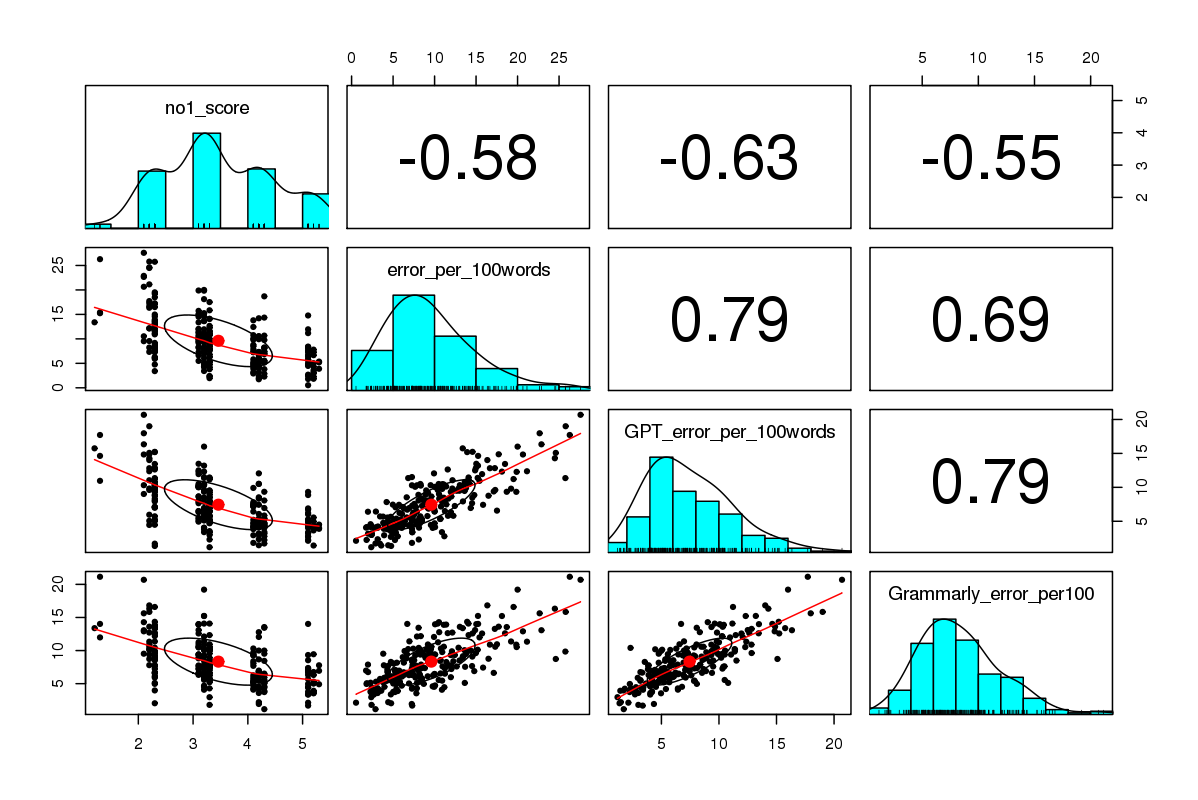

In [14]:
from PIL import Image
filename = "download.png"
Image.open(filename)
# Spearman's rank correlation coefficient (Spearman's rho)